## pop2_acp

### Imports

In [1]:
import pandas as pd
# google drive folder access
# from google.colab import drive
# drive.mount("/content/drive", force_remount=True)
# import pickle

import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn import decomposition
from sklearn import preprocessing
# classe pour l'ACP
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import RobustScaler
# classe pour k-means
from sklearn.cluster import KMeans
# classe pour cah
from scipy.cluster.hierarchy import linkage, fcluster

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
from scipy.cluster.hierarchy import dendrogram
from scipy.cluster.hierarchy import linkage, fcluster
sns.set(style="white")
sns.set_palette("GnBu_d")

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

### Load datas

In [2]:
# Table pop3_df_base.csv
path_df_base = "./datas/pop2_df_base.csv"
df_base = pd.read_csv(path_df_base, sep=',', error_bad_lines=False, index_col=0)

### Functions

In [3]:
def display_circles(pcs, n_comp, pca, axis_ranks, labels=None, label_rotation=0, lims=None):
    for d1, d2 in axis_ranks: # On affiche les 3 premiers plans factoriels, donc les 6 premières composantes
        if d2 < n_comp:

            # initialisation de la figure
            fig, ax = plt.subplots(figsize=(6,6))

            # détermination des limites du graphique
            if lims is not None :
                xmin, xmax, ymin, ymax = lims
            elif pcs.shape[1] < 30 :
                xmin, xmax, ymin, ymax = -1, 1, -1, 1
            else :
                xmin, xmax, ymin, ymax = min(pcs[d1,:]), max(pcs[d1,:]), min(pcs[d2,:]), max(pcs[d2,:])

            # affichage des flèches
            # s'il y a plus de 30 flèches, on n'affiche pas le triangle à leur extrémité
            if pcs.shape[1] < 50 :
                plt.quiver(np.zeros(pcs.shape[1]), np.zeros(pcs.shape[1]),
                   pcs[d1,:], pcs[d2,:], 
                   angles='xy', scale_units='xy', scale=1, color="grey", width=0.008)
                # (voir la doc : https://matplotlib.org/api/_as_gen/matplotlib.pyplot.quiver.html)
            else:
                lines = [[[0,0],[x,y]] for x,y in pcs[[d1,d2]].T]
                ax.add_collection(LineCollection(lines, axes=ax, alpha=.1, color='black'))
            
            # affichage des noms des variables  
            if labels is not None:  
                for i,(x, y) in enumerate(pcs[[d1,d2]].T):
                    if x >= xmin and x <= xmax and y >= ymin and y <= ymax :
                        plt.text(x, y, labels[i], fontsize='13', ha='right', va='bottom', rotation=label_rotation, color="blue", alpha=0.5)
            
            # affichage du cercle
            circle = plt.Circle((0,0), 1, facecolor='none', edgecolor='b')
            plt.gca().add_artist(circle)

            # définition des limites du graphique
            plt.xlim(xmin, xmax)
            plt.ylim(ymin, ymax)
        
            # affichage des lignes horizontales et verticales
            plt.plot([-1, 1], [0, 0], color='grey', ls='--')
            plt.plot([0, 0], [-1, 1], color='grey', ls='--')

            # nom des axes, avec le pourcentage d'inertie expliqué
            plt.xlabel('F{} ({}%)'.format(d1+1, round(100*pca.explained_variance_ratio_[d1],1)))
            plt.ylabel('F{} ({}%)'.format(d2+1, round(100*pca.explained_variance_ratio_[d2],1)))

            plt.title("Cercle des corrélations (F{} et F{})".format(d1+1, d2+1))
            plt.show(block=False)

def display_factorial_planes(X_projected, n_comp, pca, axis_ranks, labels=None, alpha=1, illustrative_var=None):
    for d1,d2 in axis_ranks:
        if d2 < n_comp:
 
            # initialisation de la figure       
            fig = plt.figure(figsize=(6,6))
        
            # affichage des points
            if illustrative_var is None:
                plt.scatter(X_projected[:, d1], X_projected[:, d2], marker='.', alpha=alpha)
            else:
                illustrative_var = np.array(illustrative_var)
                for value in np.unique(illustrative_var):
                    selected = np.where(illustrative_var == value)
                    plt.scatter(X_projected[selected, d1], X_projected[selected, d2], alpha=alpha, label=value)
                plt.legend()

            # affichage des labels des points
            if labels is not None:
                for i,(x,y) in enumerate(X_projected[:,[d1,d2]]):
                    plt.text(x, y, labels[i],
                              fontsize='10', ha='center',va='center') 
                
            # détermination des limites du graphique
            boundary = np.max(np.abs(X_projected[:, [d1,d2]])) * 1.1
            plt.xlim([-boundary,boundary])
            plt.ylim([-boundary,boundary])
        
            # affichage des lignes horizontales et verticales
            plt.plot([-100, 100], [0, 0], color='grey', ls='--')
            plt.plot([0, 0], [-100, 100], color='grey', ls='--')

            # nom des axes, avec le pourcentage d'inertie expliqué
            plt.xlabel('F{} ({}%)'.format(d1+1, round(100*pca.explained_variance_ratio_[d1],1)))
            plt.ylabel('F{} ({}%)'.format(d2+1, round(100*pca.explained_variance_ratio_[d2],1)))

            plt.title("Projection des individus (sur F{} et F{})".format(d1+1, d2+1))
            plt.show(block=False)

def display_scree_plot(pca):
    scree = pca.explained_variance_ratio_*100
    plt.bar(np.arange(len(scree))+1, scree)
    plt.plot(np.arange(len(scree))+1, scree.cumsum(),c="red",marker='o')
    plt.xlabel("rang de l'axe d'inertie")
    plt.ylabel("pourcentage d'inertie")
    plt.title("Eboulis des valeurs propres")
    plt.show(block=False)

def plot_dendrogram(Z):
#     plt.figure(figsize=(4,7))
    plt.figure(figsize=(8,4))
    plt.title('Hierarchical Clustering Dendrogram - Groupe POP2')
    plt.ylabel('distance')
    dendrogram(
        Z,
#         labels = None,
        orientation = "top",
    )
    plt.show()
    
def df_base_disp(columns_names, fig_w, fig_h):

  fig_dims = (fig_w, fig_h)
  nb_plots = len(columns_names)
  fig, axs = plt.subplots(ncols=nb_plots, figsize=fig_dims)
  skewValue = 0
  kurtosis = 0

  for i, name in enumerate(columns_names):
    # print(i, name)
    x_data =  df_base[name]
    # skewvalue
    skewValue = x_data.skew()
    # kurtosis
    kurtosis = x_data.kurtosis()
    disp = "Skew: %0.3f - kurtosis: %0.3f" % (skewValue, kurtosis)
    # print(disp)

    # plot
    # ax = sns.kdeplot(x_data, shade=True, ax=axs[i])
    ax = sns.distplot(x_data, ax=axs[i])
    # add text annotation
    ax.set_title(disp)

### Verification datas

In [4]:
print('df_base.shape :', df_base.shape)
print("Total missing values = ", df_base.isna().sum().sum())
df_base[['tage_PS', 'diplome_interv', 'revenu', 'imc', 'restaurationrapide_freq', 'collation_freq', 
         'pain_cereales_bio', 'fruits_legumes_bio', 'produits_laitiers_bio', 'viandes_poissons_bio', 
         'consommation_bio', 'tv_duree', 'ordi_duree', 'travail_duree', 'sedentarite_duree', 
         'activite_total_duree', 'activite_domloissport_duree']].describe()

df_base.shape : (2288, 21)
Total missing values =  0


,tage_PS,diplome_interv,revenu,imc,restaurationrapide_freq,collation_freq,pain_cereales_bio,fruits_legumes_bio,produits_laitiers_bio,viandes_poissons_bio,consommation_bio,tv_duree,ordi_duree,travail_duree,sedentarite_duree,activite_total_duree,activite_domloissport_duree
count,2288.000000,2288.000000,2288.000000,2288.000000,2288.000000,2288.000000,2288.000000,2288.000000,2288.000000,2288.000000,2288.000000,2288.000000,2288.000000,2288.000000,2288.000000,2288.000000,2288.000000
mean,7.867133,4.582605,8.533217,25.793700,1.569073,2.624239,0.350962,0.392045,0.695367,0.496066,0.428322,3.213525,1.870503,3.506600,6.349799,10.123324,2.398787
std,0.771601,1.907616,3.575501,4.930130,0.809681,0.975023,0.677961,0.707674,0.928269,0.736328,0.494944,1.760040,1.421218,1.711142,3.216838,3.607025,2.146942
min,7.000000,1.000000,1.000000,15.776830,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.142860,0.077308,0.035714,0.142860,0.119044,0.002976
25%,7.000000,3.000000,6.000000,22.320882,1.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,1.000000,2.429770,3.999996,7.644349,1.057664
50%,8.000000,4.000000,9.000000,25.037310,1.184441,2.066871,0.000000,0.000000,0.000000,0.000000,0.000000,3.000000,1.585665,2.429770,6.000000,10.118902,1.773805
75%,8.000000,6.000000,12.000000,28.394135,2.000000,3.000000,1.000000,1.000000,1.000000,1.000000,1.000000,4.000000,2.250825,5.000000,8.464276,12.416915,3.053947
max,9.000000,8.000000,13.000000,52.608677,6.000000,5.000000,3.000000,3.000000,3.000000,3.000000,1.000000,9.000000,9.000000,14.271429,16.997459,17.000002,25.830357


## ACP - df_base

In [17]:
# print(list(df_base))
df_base.head()

,NOIND,agglo_5cl,sex_PS,tage_PS,diplome_interv,revenu,imc,fume,restaurationrapide_freq,collation_freq,pain_cereales_bio,fruits_legumes_bio,produits_laitiers_bio,viandes_poissons_bio,consommation_bio,tv_duree,ordi_duree,travail_duree,sedentarite_duree,activite_total_duree,activite_domloissport_duree
0,110100101,1,1,7,3.0,12,18.282312,0.0,2.000000,5.000000,1,0,1.0,0,0.0,2.142860,3.571430,2.429770,8.142860,8.614090,0.110119
1,110100701,1,2,8,3.0,11,23.624619,0.0,1.000000,1.000000,1,2,2.0,2,1.0,1.928570,0.357140,4.000000,6.666670,10.569450,3.160715
2,110100801,1,1,8,3.0,11,29.949701,1.0,1.000000,2.066871,0,0,0.0,0,0.0,0.928570,0.142860,2.429770,1.714290,3.015881,1.178572
3,110101201,1,1,8,6.0,11,26.141914,0.0,1.000000,3.000000,0,0,0.0,0,0.0,3.023461,4.031272,5.714286,13.664864,17.000000,3.422618
4,110101401,1,2,9,3.0,6,22.420361,0.0,1.184441,2.000000,1,0,3.0,1,1.0,1.500000,1.585665,2.429770,1.500000,3.882939,2.160719


In [22]:
# choix du nombre de composantes à calculer
n_comp = 8

# selection des colonnes à prendre en compte dans l'ACP
data_pca = df_base[['revenu', 'imc', 'restaurationrapide_freq', 'collation_freq', 'fruits_legumes_bio', 
                    'tv_duree', 'travail_duree', 'activite_total_duree']]

# Utile pour définitions clusters CAH
revenu = [df_base.loc[id, "revenu"] for id in df_base.index]

# préparation des données pour l'acp
X = data_pca.values
# names = df_base.index
names = df_base['NOIND']
# features = df_base.columns
features = ['sex_PS', 'tage_PS', 'diplome_interv', 'revenu', 'imc', 'fume', 'restaurationrapide_freq', 
            'collation_freq', 'consommation_bio', 'fruits_legumes_bio', 'tv_duree', 'travail_duree', 
            'activite_total_duree']

# Centrage et Réduction
std_scale = preprocessing.StandardScaler().fit(X)
X_scaled = std_scale.transform(X)

# vérification moyenne
print(np.mean(X_scaled,axis=0))
# vérification écart-type
print(np.std(X_scaled,axis=0,ddof=0))

# print(X_scaled)

[-5.27938222e-17 -6.98741764e-17 -2.79496706e-17 -3.08999136e-16
 -5.43465816e-18  1.68474403e-16  1.69250783e-16 -1.91765795e-16]
[1. 1. 1. 1. 1. 1. 1. 1.]


## Choix du nombre de composantes

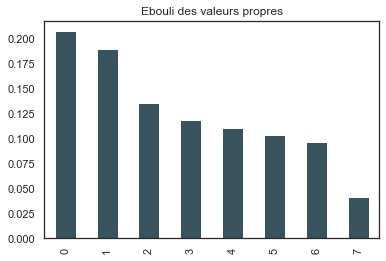

In [8]:
# Calcul des composantes principales
pca = decomposition.PCA(n_components=n_comp)
# principalComponents = pca.fit(X_scaled)
principalComponents = pca.fit_transform(X_scaled)

# Ebouli
ebouli = pd.Series(pca.explained_variance_ratio_)
ebouli.plot(kind='bar', title="Ebouli des valeurs propres")
plt.show()

In [9]:
# Calcul des composantes principales
n_comp_selected = 6
pca = decomposition.PCA(n_components=n_comp_selected)
principalComponents = pca.fit_transform(X_scaled)

### Cercle des corrélations - df_base

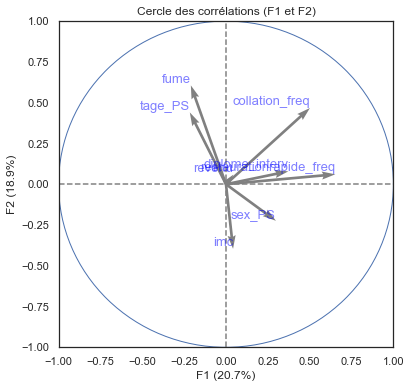

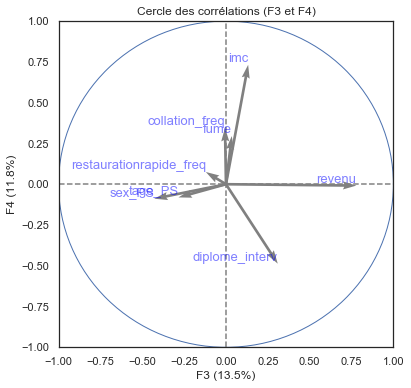

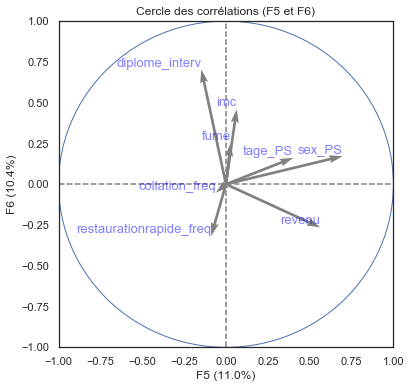

In [10]:
# Cercle des corrélations
pcs = pca.components_
display_circles(pcs, n_comp_selected, pca, [(0,1),(2,3),(4,5)], labels = np.array(features))

### Projection des individus - df_base

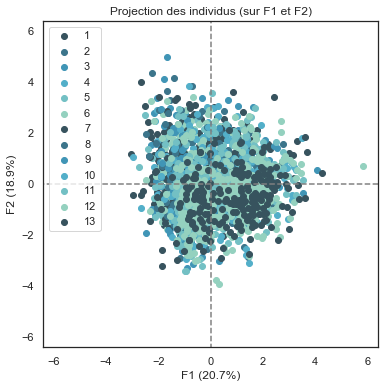

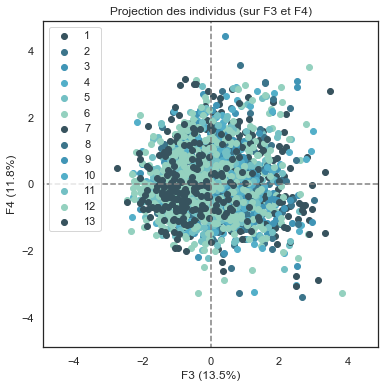

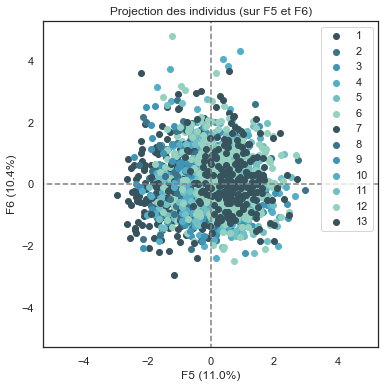

In [24]:
# Projection des individus
X_projected = pca.transform(X_scaled)
display_factorial_planes(X_projected, n_comp_selected, pca, [(0,1),(2,3),(4,5)], illustrative_var = revenu, labels = None)

plt.show()

## CAH - df_base

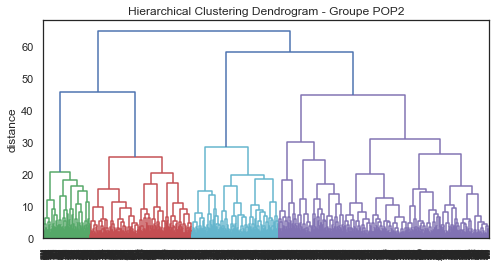

In [12]:
# Clustering hiérarchique
Z = linkage(X_scaled, 'ward')

# Affichage du dendrogramme
plot_dendrogram(Z)

## k-means - df_base

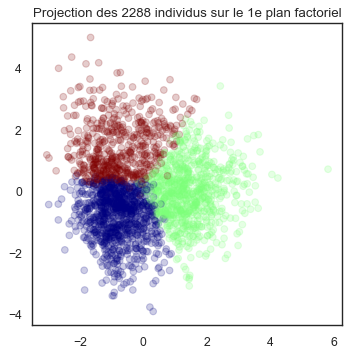

In [25]:
# Nombre de clusters souhaités
n_clust = 3

# import de l'échantillon
data_km = data_pca

# préparation des données pour le clustering
X = data_km.values

# Réduire n'est ici pas nécessaire car les variables sont exprimées dans la même unité
X_scaled = preprocessing.StandardScaler().fit_transform(X)

# Clustering par K-means
km = KMeans(n_clusters=n_clust)
km.fit(X_scaled)

# Récupération des clusters attribués à chaque individu
clusters = km.labels_

# Affichage du clustering par projection des individus sur le premier plan factoriel
pca = decomposition.PCA(n_components=6).fit(X_scaled)
X_projected = pca.transform(X_scaled)
plt.figure(figsize=(5, 5), dpi=80)
plt.scatter(X_projected[:, 0], X_projected[:, 1], c=clusters.astype(np.float), cmap = 'jet', alpha=.2)
plt.title("Projection des {} individus sur le 1e plan factoriel".format(X_projected.shape[0]))

plt.show(block=False)